In [1]:
# Copyright (C) 2025 Intel Corporation
# SPDX-License-Identifier: Apache-2.0

# DINOv3 Zero-Shot Classification Example

This notebook demonstrates how to use DINOv3 for zero-shot classification on ImageNet data.

## Overview
- Load ImageNet dataset with subset directories
- Initialize DinoTxt pipeline for zero-shot classification
- Learn from text prompts (class names)
- Perform inference on target images
- Calculate classification accuracy


## Setup and Imports

In [2]:
import timeit
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch

from getiprompt.data import Batch, Sample
from getiprompt.data.utils.image import read_image
from getiprompt.models.dinotxt import DinoTxtZeroShotClassification
from getiprompt.utils.constants import DINOv3BackboneSize

/home/yuchunli/git/geti-prompt/library/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yuchunli/git/geti-prompt/library/.venv/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/yuchunli/git/geti-prompt/library/.venv/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/yuchunli/git/geti-prompt/library/.venv/lib/python3.12/site-packages/segment_anything_hq/modeling/tiny_v

## Configuration

Set your parameters here:


In [3]:
# Configuration parameters
data_root = Path("../tests/assets/fss-1000/images")
precision = "bf16"  # Options: "bf16", "fp16", "fp32"

## Load Dataset


In [4]:
# Import dataset
label_names = []
target_images = []
gt_label_names = []
for path in data_root.rglob("*/*.jpg"):
    label_name = path.parent.name
    if label_name not in label_names:
        label_names.append(label_name)
    gt_label_names.append(label_name)
    img = read_image(path, as_tensor=True)
    target_images.append(img)

gt_labels = [label_names.index(gt_label_name) for gt_label_name in gt_label_names]

print(f"Dataset loaded with {len(label_names)} classes")
print(f"Total items: {len(target_images)}")
print(f"Example classes: {label_names}")

Dataset loaded with 2 classes
Total items: 20
Example classes: ['apple', 'basketball']


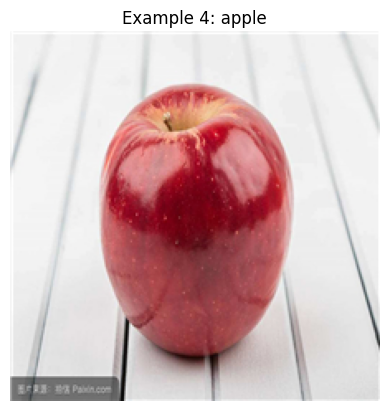

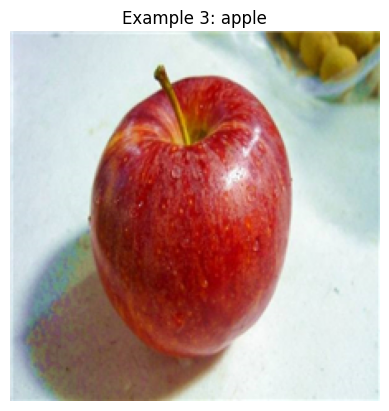

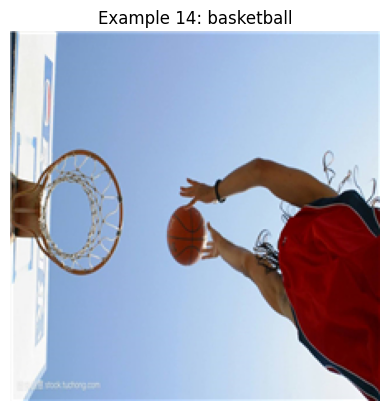

In [5]:
# Display a few random example images with matplotlib
random_indices = np.random.Generator(np.random.PCG64()).permutation(len(target_images))[:3]
for i in random_indices:
    img = target_images[i]
    label = label_names[gt_labels[i]]
    plt.imshow(img.numpy().transpose(1, 2, 0))
    plt.title(f"Example {i + 1}: {label}")
    plt.axis("off")
    plt.show()

## Prepare Target Images and Ground Truth Labels


## Initialize DinoTxt Pipeline


In [6]:
# Initialize DinoTxt pipeline
print("Initializing DinoTxt pipeline...")
dinotxt = DinoTxtZeroShotClassification(precision=precision, backbone_size=DINOv3BackboneSize.LARGE)
print("Pipeline initialized successfully!")

Initializing DinoTxt pipeline...


Using cache found in /home/yuchunli/.cache/torch/hub/facebookresearch_dinov3_main


Pipeline initialized successfully!


## Learn from Text Prompts

In [7]:
# Learn from text prompts (class names)
print("Learning from text prompts...")
start_time = timeit.default_timer()

samples = [
    Sample(
        categories=label_names[label_id],
        category_ids=[label_id],
        is_reference=[True],
    )
    for label_id in range(len(label_names))
]
batch = Batch.collate(samples)

dinotxt.learn(batch)

learn_time = timeit.default_timer() - start_time
print(f"Learning completed in {learn_time:.2f} seconds")

Learning from text prompts...
Learning completed in 0.45 seconds


## Perform Inference


In [8]:
# Perform inference on target images
print("Starting inference...")
inference_start_time = timeit.default_timer()

target_samples = [
    Sample(
        image=image,
        categories=[gt_label_name],
        category_ids=[gt_label],
        is_reference=[False],
    )
    for image, gt_label, gt_label_name in zip(target_images, gt_labels, gt_label_names, strict=True)
]
target_batch = Batch.collate(target_samples)
predictions = dinotxt.infer(target_batch=target_batch)

# Convert to tensors
pred_labels = torch.stack([prediction["pred_labels"] for prediction in predictions]).cuda()
gt_labels = torch.tensor(gt_labels).cuda()

inference_time = timeit.default_timer() - inference_start_time
print(f"Inference completed in {inference_time:.2f} seconds")

Starting inference...
Inference completed in 0.62 seconds


## Calculate Results


In [9]:
# Calculate zero-shot classification accuracy
accuracy = sum(pred_labels == gt_labels) / len(gt_labels)
total_time = timeit.default_timer() - start_time

print("=" * 50)
print("RESULTS")
print("=" * 50)
print(f"Accuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)")
print(f"Total time: {total_time:.2f} seconds")
print(f"Time per image: {total_time / len(target_images):.4f} seconds")
print(f"Images processed: {len(target_images)}")
print(f"Precision: {precision}")
print("=" * 50)

RESULTS
Accuracy: 0.4000 (40.00%)
Total time: 1.12 seconds
Time per image: 0.0558 seconds
Images processed: 20
Precision: bf16
